In [1]:
from sim import *
import numpy as np
import sim as simmod  # for setting module globals (DISTANCE, TRUE_SIGNAL_DOA)

In [2]:
FLIGHT_TIME_SEC = 160.0
UPDATE_RATE_HZ = 25000  # snapshots per second
NUM_TOTAL_SNAPSHOTS = int(FLIGHT_TIME_SEC * UPDATE_RATE_HZ)  # 4,000,000

# Sliding-window settings
WINDOW_SIZE = 1000

In [ ]:
def flight_xyz(t_sec: float):
    x = 160.0 - t_sec
    y = t_sec
    if t_sec < 20.0:
        z = -2.8 * t_sec * (t_sec - 155.0)
    else:
        z = -54.0 * t_sec + 8640.0
    return x, y, z

Plotting the flight path

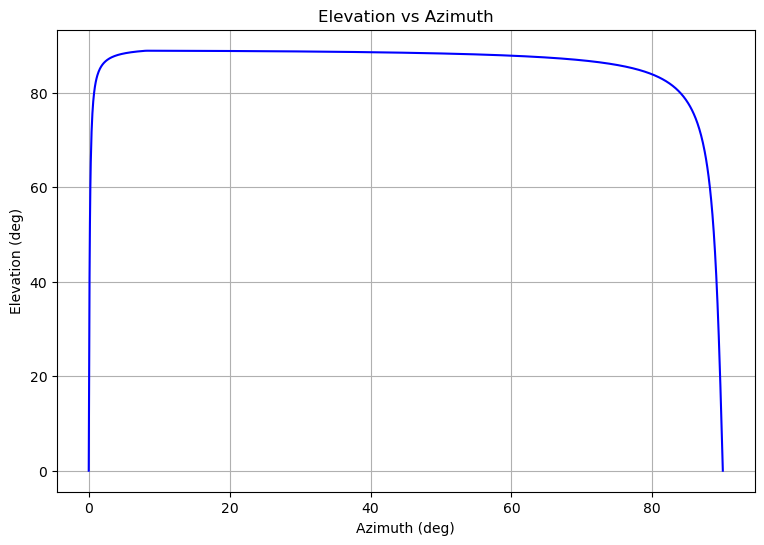

In [4]:
# Convert the flight path to azimuth and elevation and plot elevation (y) vs azimuth (x)
import numpy as np
import matplotlib.pyplot as plt

# Use a reasonable number of points for plotting
num_points = 1000
_time = np.linspace(0.0, FLIGHT_TIME_SEC, num_points)

# Horizontal path
x_path = 160.0 - _time
y_path = _time

# Vertical path (piecewise)
z_path = np.zeros_like(_time)
mask1 = _time < 20.0
mask2 = ~mask1
z_path[mask1] = -2.8 * _time[mask1] * (_time[mask1] - 155.0)
z_path[mask2] = -54.0 * _time[mask2] + 8640.0

# Convert to azimuth (phi) and elevation (theta above horizon)
r_xy = np.hypot(x_path, y_path)
# Elevation above horizon: 0° at horizon, +90° at zenith
elevation_deg = np.rad2deg(np.arctan2(z_path, r_xy))
# Azimuth in XY plane from +X toward +Y, range [-180, 180]
azimuth_deg = np.rad2deg(np.arctan2(y_path, x_path))

# Plot elevation vs azimuth
plt.figure(figsize=(9, 6))
plt.plot(azimuth_deg, elevation_deg, 'b-')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')
plt.title('Elevation vs Azimuth')
plt.grid(True)
plt.show()

In [6]:
# Use a reasonable number of points for plotting
num_points = 2500000
_time = np.linspace(0.0, FLIGHT_TIME_SEC, num_points)

# Horizontal path
x_path = 160.0 - _time
y_path = _time

# Vertical path (piecewise)
z_path = np.zeros_like(_time)
mask1 = _time < 20.0
mask2 = ~mask1
z_path[mask1] = -2.8 * _time[mask1] * (_time[mask1] - 155.0)
z_path[mask2] = -54.0 * _time[mask2] + 8640.0

# Convert to azimuth (phi) and elevation (theta above horizon)
r_xy = np.hypot(x_path, y_path)
# Elevation above horizon: 0° at horizon, +90° at zenith
elevation_deg = np.rad2deg(np.arctan2(z_path, r_xy))
# Azimuth in XY plane from +X toward +Y, range [-180, 180]
azimuth_deg = np.rad2deg(np.arctan2(y_path, x_path))


In [9]:
# Sliding-window 2D DOA over azimuth/elevation arrays and plot Elevation vs Azimuth
import numpy as np
import matplotlib.pyplot as plt

# Parameters
WINDOW_SIZE_DOA = 100
HOP_SIZE = 100

# Ensure required arrays exist (from previous cell)
num_samples = len(azimuth_deg)
num_windows = 1 + (num_samples - WINDOW_SIZE_DOA) // HOP_SIZE

# Precompute scan grid once
theta_scan = np.linspace(0, 90, 91)  # Elevation grid (deg)
phi_scan = np.linspace(0, 360, 361)  # Azimuth grid (deg)
A_scan = precompute_steering_vectors(theta_scan, phi_scan)

true_elev, true_az = [], []
est_elev, est_az = [], []

In [10]:
tx_iq = modulate(PAYLOAD)  # from sim.py (preamble + payload chirps)
last_start = (num_windows - 1) * HOP_SIZE
L_needed = last_start + WINDOW_SIZE_DOA
lora_stream = np.resize(tx_iq, L_needed)  # wrap/repeat to fill


In [11]:
for w in range(num_windows):
    start = w * HOP_SIZE
    center = start + WINDOW_SIZE_DOA // 2

    # Ground-truth angles for this window (from trajectory)
    theta_true = elevation_deg[center]
    phi_true = azimuth_deg[center]

    # Ground-truth distance for FSPL (optional but harmless)
    dist = np.sqrt(x_path[center]**2 + y_path[center]**2 + z_path[center]**2)

    # Update simulator globals (in sim module)
    simmod.TRUE_SIGNAL_DOA[0] = theta_true
    simmod.TRUE_SIGNAL_DOA[1] = phi_true
    simmod.DISTANCE = dist

    # Use LoRa IQ segment for this window (replaces constant tone)
    S_win = lora_stream[start:start + WINDOW_SIZE_DOA]

    # Simulate array measurements and add noise
    rx_signal = receive_signal(S_win)
    rx_signal_fspl = add_FSPL(rx_signal)
    rx_noisy = add_gaussian_noise(rx_signal_fspl)

    # 2D MUSIC
    R = (rx_noisy @ rx_noisy.conj().T) / rx_noisy.shape[1]
    eigvals, eigvecs = np.linalg.eigh(R)
    En = eigvecs[:, :-1]  # assume one source
    Pmusic = compute_Pmusic(A_scan, En)
    peak_idx = np.unravel_index(np.argmax(Pmusic), Pmusic.shape)
    theta_est = theta_scan[peak_idx[0]]
    phi_est = phi_scan[peak_idx[1]]

    true_elev.append(theta_true)
    true_az.append(phi_true)
    est_elev.append(theta_est)
    est_az.append(phi_est)

    if w % max(1, num_windows // 10) == 0:
        print(f"win {w+1}/{num_windows}: true(el={theta_true:.1f}, az={phi_true:.1f}) -> est(el={theta_est:.1f}, az={phi_est:.1f})")

# Wrap azimuths to [0, 360) for clean plotting
true_az_plot = (np.array(true_az) + 360) % 360
est_az_plot = (np.array(est_az) + 360) % 360
true_elev = np.array(true_elev)
est_elev = np.array(est_elev)



win 1/25000: true(el=0.5, az=0.0) -> est(el=0.0, az=0.0)
win 2501/25000: true(el=88.7, az=6.3) -> est(el=90.0, az=6.0)
win 2501/25000: true(el=88.7, az=6.3) -> est(el=90.0, az=6.0)
win 5001/25000: true(el=88.9, az=14.0) -> est(el=87.0, az=14.0)
win 5001/25000: true(el=88.9, az=14.0) -> est(el=87.0, az=14.0)
win 7501/25000: true(el=88.8, az=23.2) -> est(el=90.0, az=23.0)
win 7501/25000: true(el=88.8, az=23.2) -> est(el=90.0, az=23.0)
win 10001/25000: true(el=88.7, az=33.7) -> est(el=90.0, az=34.0)
win 10001/25000: true(el=88.7, az=33.7) -> est(el=90.0, az=34.0)
win 12501/25000: true(el=88.5, az=45.0) -> est(el=88.0, az=45.0)
win 15001/25000: true(el=88.1, az=56.3) -> est(el=87.0, az=56.0)
win 17501/25000: true(el=87.3, az=66.8) -> est(el=87.0, az=67.0)
win 20001/25000: true(el=85.6, az=76.0) -> est(el=86.0, az=76.0)
win 22501/25000: true(el=80.5, az=83.7) -> est(el=80.0, az=84.0)


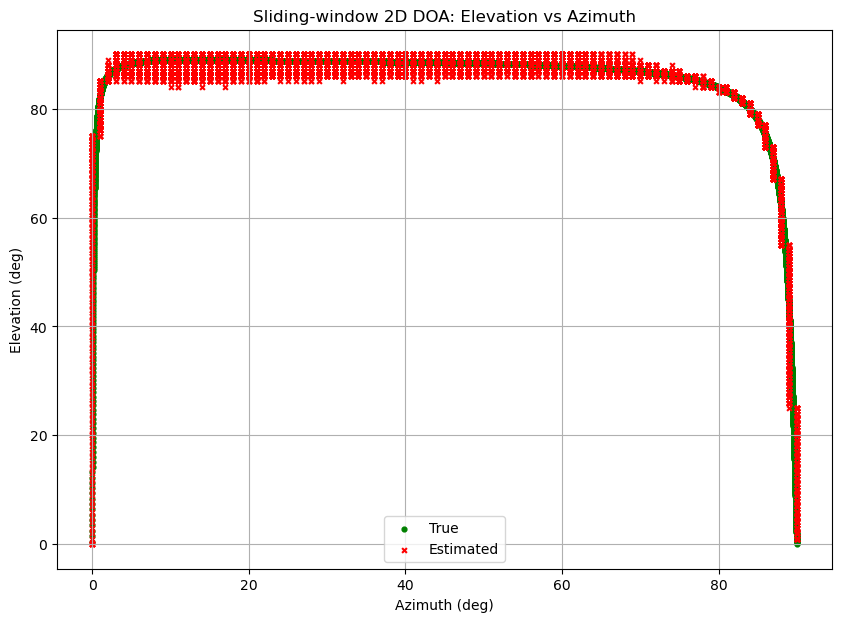

In [13]:
# Plot Elevation (y) vs Azimuth (x)
plt.figure(figsize=(10, 7))
plt.scatter(true_az_plot, true_elev, c='green', s=12, label='True')
plt.scatter(est_az_plot, est_elev, c='red', s=12, marker='x', label='Estimated')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Elevation (deg)')
plt.title('Sliding-window 2D DOA: Elevation vs Azimuth')
plt.grid(True)
plt.legend()
plt.show()

Elevation error: mean=0.89 deg, RMSE=1.15 deg
Azimuth error:   mean=0.27 deg, RMSE=1.18 deg


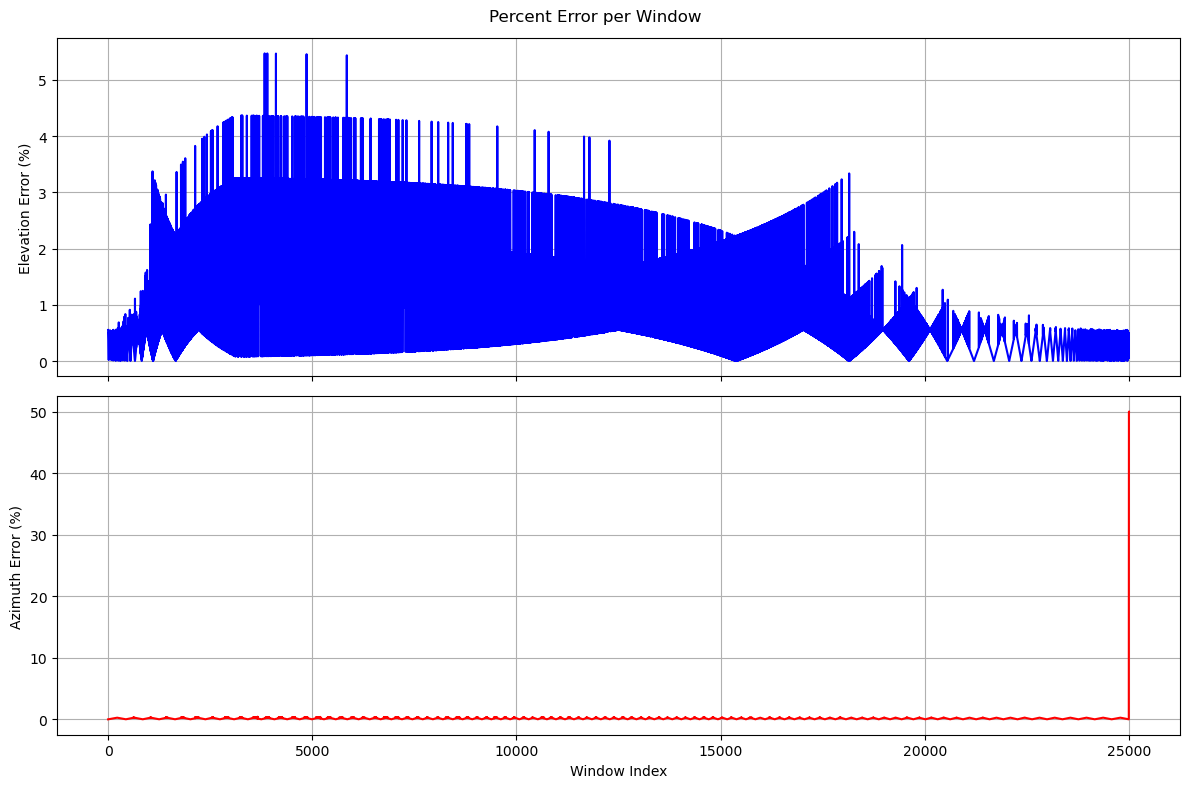

In [14]:
# Compute angular error arrays and plot percent error
import numpy as np
import matplotlib.pyplot as plt

# Ensure arrays
true_elev_arr = np.asarray(true_elev)
est_elev_arr = np.asarray(est_elev)
true_az_arr = np.asarray(true_az)
est_az_arr = np.asarray(est_az)

# Circular azimuth error in degrees (minimal signed difference in [-180, 180])
az_err_deg = (est_az_arr - true_az_arr + 180.0) % 360.0 - 180.0
# Elevation error (straight difference)
elev_err_deg = est_elev_arr - true_elev_arr

# Percent errors
percent_az_err = np.abs(az_err_deg) / 180.0 * 100.0   # 100% at 180 deg error
percent_elev_err = np.abs(elev_err_deg) / 90.0 * 100.0 # 100% at 90 deg error

# Print summary
print(f"Elevation error: mean={np.mean(np.abs(elev_err_deg)):.2f} deg, RMSE={np.sqrt(np.mean(elev_err_deg**2)):.2f} deg")
print(f"Azimuth error:   mean={np.mean(np.abs(az_err_deg)):.2f} deg, RMSE={np.sqrt(np.mean(az_err_deg**2)):.2f} deg")

# Plot percent error vs window index
x_idx = np.arange(len(percent_elev_err))
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
axes[0].plot(x_idx, percent_elev_err, 'b-')
axes[0].set_ylabel('Elevation Error (%)')
axes[0].grid(True)

axes[1].plot(x_idx, percent_az_err, 'r-')
axes[1].set_xlabel('Window Index')
axes[1].set_ylabel('Azimuth Error (%)')
axes[1].grid(True)

plt.suptitle('Percent Error per Window')
plt.tight_layout()
plt.show()